In [1]:
import tensorflow as tf
import numpy as np
from __future__ import print_function

In [2]:
def dptable(state_prob):
    print(" ".join(("%10d" % i) for i in range(state_prob.shape[0])))
    for i, prob in enumerate(state_prob.T):
        print("%.7s: " % states[i] +" ".join("%.7s" % ("%f" % p) for p in prob))

In [15]:
class HiddenMarkovModel(object):

    """
    Hidden Markov Model Class

    Parameters:
    -----------
    
    - S: Number of states.
    - T: Transition matrix of size S by S
         stores probability from state i to state j.
    - E: Emission matrix of size S by N (number of observations)
         stores the probability of observing  O_j  from state  S_i. 
    - T0: Initial state probabilities of size S.
    """

    def __init__(self, T, E, T0):
        # Number of possible states
        self.S = T.shape[0]
        
        # Number of possible observations
        self.O = E.shape[0]
        
        # Emission probability
        self.E = tf.Variable(E, dtype=tf.float64, name='emission_matrix')

        # Transition matrix
        self.T = tf.Variable(T, dtype=tf.float64, name='transition_matrix')

        # Initial state vector
        self.T0 = tf.constant(T0, dtype=tf.float64, name='inital_state_vector')
    
    def initialize_variables(self, shape, shape_ext):
        self.forward = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='forward')
        self.backward = tf.Variable(tf.zeros(shape_ext, dtype=tf.float64), name='backward')
        self.posterior = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='posteriror')


    def _forward(self, obs_prob_list):
        # initialize with state starting priors
        init_prob = tf.mul(self.T0, tf.squeeze(obs_prob_list[0]))
        self.forward = tf.scatter_update(self.forward, 0, init_prob)

        # propagate belief
        for step, obs_prob in enumerate(obs_prob_list[1:]):
            # previous state probability
            prev_prob = tf.expand_dims(self.forward[step, :], 0)
            # transition prior
            prior_prob = tf.matmul(prev_prob, self.T)
            # forward belief propagation
            forward_score = tf.mul(prior_prob, tf.squeeze(obs_prob))
            # Normalize score into a probability
            #forward_prob = tf.squeeze(forward_score / tf.reduce_sum(forward_score))
            forward_prob = tf.squeeze(forward_score)
            # Update forward matrix
            self.forward = tf.scatter_update(self.forward, step+1, forward_prob)

        # remove initial probability
        #self.forward = tf.slice(self.forward, [1,0], [self.N, self.S]) 
        

    def _backward(self, obs_prob_list):
        # initialize with state ending priors
        self.backward = tf.scatter_update(self.backward, 0, tf.ones([self.S], dtype=tf.float64)) 

        # propagate belief
        for step, obs_prob in enumerate(obs_prob_list):
            # next state probability
            next_prob = tf.expand_dims(self.backward[step, :], 1)
            # observation emission probabilities
            obs_prob_d = tf.diag(tf.squeeze(obs_prob))
            # transition prior
            prior_prob = tf.matmul(self.T, obs_prob_d)
            # backward belief propagation
            backward_score = tf.matmul(prior_prob, next_prob)
            # Normalize score into a probability
            #backward_prob = tf.squeeze(backward_score / tf.reduce_sum(backward_score))
            backward_prob = tf.squeeze(backward_score)

            # Update backward matrix
            self.backward = tf.scatter_update(self.backward, step+1, backward_prob)
        
        self.backward = tf.reverse(self.backward, [True, False])
        # remove final probability
        self.backward = tf.slice(self.backward, [0,0], [self.N, self.S])
        
    def _posterior(self):
        # posterior score
        self.posterior = tf.mul(self.forward, self.backward)
        
        # marginal per timestep
        #marginal = tf.reduce_sum(self.forward[self.N-1, :], 0)
        marginal = tf.reduce_sum(self.posterior, 1)
#         init_prob = tf.mul(self.T0, tf.squeeze(obs_prob_list[0])) #2x1
        
        # Normalize porsterior into probabilities
        self.posterior = self.posterior / tf.expand_dims(marginal, 1)       
        
        
    def re_estimate_emission(self, x):
        
        states_marginal = tf.reduce_sum(self.posterior, 0)
        seq_one_hot = tf.one_hot(tf.cast(x, tf.int64), self.O, 1, 0)
        emission_score = tf.matmul(tf.cast(seq_one_hot, tf.float64), self.posterior, transpose_a=True)
        return emission_score / states_marginal
    
    def re_estimate_transition(self, x):
        
        self.M = tf.Variable(tf.zeros((self.N-1, self.S, self.S), tf.float64))
        
        for t in range(self.N - 1):
            tmp_0 = tf.matmul(tf.expand_dims(self.forward[t, :], 0), self.T)
            tmp_1 = tf.mul(tmp_0, tf.expand_dims(tf.gather(self.E, x[t+1]), 0))
            denom = tf.squeeze(tf.matmul(tmp_1, tf.expand_dims(self.backward[t+1, :], 1)))

            trans_re_estimate = tf.Variable(tf.zeros((self.S, self.S), tf.float64))
            for i in range(self.S):
                numer = self.forward[t, i] * self.T[:, i] * tf.gather(self.E, x[t+1]) * self.backward[t+1, :]
                trans_re_estimate = tf.scatter_update(trans_re_estimate, i, numer / denom)

            self.M = tf.scatter_update(self.M, t, trans_re_estimate)
            return tf.reduce_sum(self.M, 0) / tf.expand_dims(tf.reduce_sum(self.posterior, 0), 0)
        
    def forward_backward(self, obs_seq):
        """
        runs forward backward algorithm on observation sequence

        Arguments
        ---------
        - obs_seq : matrix of size N by S, where N is number of timesteps and
            S is the number of states

        Returns
        -------
        - forward : matrix of size N by S representing
            the forward probability of each state at each time step
        - backward : matrix of size N by S representing
            the backward probability of each state at each time step
        - posterior : matrix of size N by S representing
            the posterior probability of each state at each time step
        """

        # length of observed sequence
        self.N = len(obs_seq)

        # shape of Variables
        shape = [self.N, self.S]
        shape_ext = [self.N+1, self.S]
        
        # observed sequence
        x = tf.constant(obs_seq, dtype=tf.int32, name='observation_sequence')
        
        # initialize variables
        self.initialize_variables(shape, shape_ext)
        
        # probability of emission sequence
        obs_prob_seq = tf.gather(self.E, x)
        
        obs_prob_list_for = tf.split(0, self.N, obs_prob_seq)
        
        # forward belief propagation
        self._forward(obs_prob_list_for)
        
        obs_prob_seq_rev = tf.reverse(obs_prob_seq, [True, False])
        obs_prob_list_back = tf.split(0, self.N, obs_prob_seq_rev)
        
        # backward belief propagation
        self._backward(obs_prob_list_back)

        # apply smoothing
        self._posterior()
        
        new_emission = self.re_estimate_emission(x)
        new_transition = self.re_estimate_transition(x)

        self.E = new_emission
        self.T = new_transition
        return self.forward, self.backward, self.posterior, self.E, self.T
    
    def run_forward_backward(self, obs_seq):
        with tf.Session() as sess:
            
            forward, backward, posterior, emission, trans = self.forward_backward(obs_seq)
            sess.run(tf.initialize_all_variables())
            return sess.run([forward, backward, posterior, emission, trans])

In [16]:
p0 = np.array([0.8, 0.2])

emi = np.array([[0.3, 0.4],
                [0.4, 0.3],
                [0.3, 0.3]])

trans = np.array([[0.6, 0.4],
                  [0.3, 0.7]])

states = {0:'S1', 1:'S2'}
obs = {0:'R', 1:'W', 2:'B'}

# {ABBA, BAB}
obs_seq = np.array([0, 1, 2, 2])


In [17]:
model =  HiddenMarkovModel(trans, emi, p0)

results = model.run_forward_backward(obs_seq)
for i in results:
    print(i)
    print()

[[ 0.24       0.08     ]
 [ 0.0672     0.0456   ]
 [ 0.0162     0.01764  ]
 [ 0.0045036  0.0056484]]

[[ 0.010584  0.011232]
 [ 0.0324    0.0297  ]
 [ 0.09      0.09    ]
 [ 0.3       0.3     ]]

[[ 0.73869347  0.26130653]
 [ 0.61651376  0.38348624]
 [ 0.4787234   0.5212766 ]
 [ 0.44361702  0.55638298]]

[[ 0.32433722  0.1517061 ]
 [ 0.27069193  0.22263968]
 [ 0.40497086  0.62565422]]

[[ 0.23202165  0.1054609 ]
 [ 0.05156037  0.08202515]]



In [18]:
P = np.array([[ 0.73869347,  0.26130653],
 [ 0.61651376 , 0.38348624],
 [ 0.4787234,   0.5212766 ],
 [ 0.44361702,  0.55638298]])

back = np.array([[ 0.010584,  0.011232],
 [ 0.0324,    0.0297  ],
 [ 0.09 ,     0.09    ],
 [ 0.3   ,    0.3     ]])

forw = np.array([[ 0.24 ,      0.08     ],
 [ 0.0672   ,  0.0456   ],
 [ 0.0162   ,  0.01764  ],
 [ 0.0045036,  0.0056484]])

In [7]:
sess = tf.InteractiveSession()

In [8]:
x = tf.constant(obs_seq, dtype=tf.int32)
f = tf.constant(forw, dtype=tf.float64)
b = tf.constant(back, dtype=tf.float64)
T = tf.constant(trans, dtype=tf.float64)
E = tf.constant(emi, dtype=tf.float64)
P_m = tf.constant(P, dtype=tf.float64)

In [9]:
N = 4
S = 2
x_i = tf.Variable(tf.zeros((N-1, S, S), tf.float64))

for t in range(N -1):
    x_0 = tf.matmul(tf.expand_dims(f[t, :], 0), T)
    x_1 = tf.mul(x_0, tf.expand_dims(tf.gather(E, x[t+1]), 0))
    denom = tf.squeeze(tf.matmul(x_1, tf.expand_dims(b[t+1, :], 1)))
    
    p = tf.Variable(tf.zeros((S,S), tf.float64))
    for i in range(S):
        numer = f[t, i] * T[:, i] * tf.gather(E, x[t+1]) * b[t+1, :]
        p = tf.scatter_update(p, i, numer / denom)
    
    x_i = tf.scatter_update(x_i, t, p)
    new_transition = tf.reduce_sum(x_i, 0) / tf.expand_dims(tf.reduce_sum(P_m, 0), 0)

In [10]:
sess.run(tf.initialize_all_variables())
sess.run(new_transition )

array([[ 0.51508087,  0.2926013 ],
       [ 0.21410922,  0.45815882]])

In [38]:
N = 4
for t in range(N -1):
    x_0 = np.dot(forw[t, :], trans)
    x_1 = x_0 * emi[obs_seq[t+1], :]
    print(np.dot(x_1, back[t+1, :]))

t = 0
for i in range(2):
    print(forw[t, i] * trans[:, i].T * emi[obs_seq[t+1], :] * back[t+1, :])

0.0035316
0.0030456
0.0030456
[ 0.00186624  0.00064152]
[ 0.00041472  0.00049896]


In [23]:
trans[:, i]

array([ 0.6,  0.3])

In [79]:
P_m = tf.constant(P)
P_marginal = tf.reduce_sum(P_m, 0)
x = tf.constant(obs_seq, dtype=tf.int32)
a = tf.one_hot(tf.cast(x, tf.int64), 3, 1, 0)
(tf.matmul(tf.cast(a, tf.float64), P_m, transpose_a=True) / P_marginal).eval()

array([[ 0.32433722,  0.1517061 ],
       [ 0.27069193,  0.22263968],
       [ 0.40497086,  0.62565422]])

In [13]:
hmm.simulate(10)

(array([ 2.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.]))

In [3]:
from hmmestimate import HMM
import matplotlib.pyplot as plt
%matplotlib inline

/Users/marvinbertin/anaconda/envs/TensorFlow-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
np.set_printoptions(precision=3,suppress=True)

In [5]:
hmm = HMM()
hmm.pi = np.array([0.5, 0.5])
hmm.A = np.array([[0.85, 0.15],
                  [0.12, 0.88]])
hmm.B = np.array([[0.8, 0.1, 0.1],
                  [0.0, 0.0, 1]])
hmmguess = HMM()
hmmguess.pi = np.array([0.5, 0.5])
hmmguess.A = np.array([[0.5, 0.5],
                       [0.5, 0.5]])
hmmguess.B = np.array([[0.3, 0.3, 0.4],
                       [0.2, 0.5, 0.3]])

Actual probabilities
 [ 0.5  0.5]
Estimated initial probabilities
 [ 0.  1.]
Actual state transition probabililities
 [[ 0.85  0.15]
 [ 0.12  0.88]]
Estimated state transition probabililities
 [[ 0.934  0.066]
 [ 0.148  0.852]]
Actual observation probabililities
 [[ 0.8  0.1  0.1]
 [ 0.   0.   1. ]]
Estimated observation probabililities
 [[ 0.664  0.185  0.15 ]
 [ 0.     0.     1.   ]]


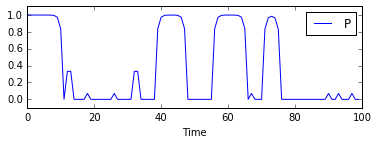

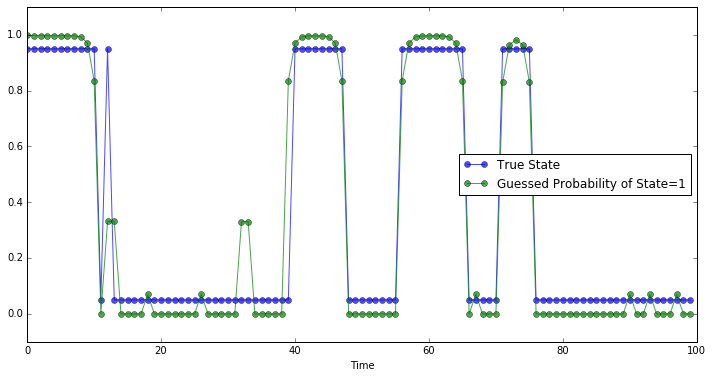

In [9]:
o,s = hmm.simulate(100)
hmmguess.train(o,0.0001,graphics=True)

print('Actual probabilities\n',hmm.pi)
print ('Estimated initial probabilities\n',hmmguess.pi)

print ('Actual state transition probabililities\n',hmm.A)
print ('Estimated state transition probabililities\n',hmmguess.A)

print ('Actual observation probabililities\n',hmm.B)
print ('Estimated observation probabililities\n',hmmguess.B)

#plt.subplot(2,1,2)
plt.figure(figsize=(12,6))
plt.cla()
plt.plot(np.vstack((s*0.9+0.05,hmmguess.gamma[1,:])).T,'-o',alpha=0.7)
plt.legend(('True State','Guessed Probability of State=1'), loc = 'center right')
plt.ylim(-0.1,1.1)
plt.xlabel('Time')
plt.draw()